## Imports

In [3]:
%env CUDA_VISIBLE_DEVICES=1
%matplotlib inline

env: CUDA_VISIBLE_DEVICES=1


In [4]:
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import tensorflow as tf
import data.data_selector as ds
import utils.data_processing as dp
import utils.plot_functions as pf
import analysis.analysis_picker as ap

In [5]:
analysis_params = [{
  #"model_type": "ica",
  #"model_name": "ica_test",
  #"version": "0.0",
  #"weights": "weights/a_inverse:0",
  #"save_info": "analysis",
  #"overwrite_analysis": False},

  "model_type": "sparse_autoencoder",
  "model_name": "sparse_autoencoder",
  "version": "0.0",
  "weights": "weights/w_enc:0",
  "save_info": "analysis",
  "overwrite_analysis": False},

  {"model_type": "lca",
  "model_name": "lca_256_l0_2.5",
  "version": "1.0",
  "weights": "weights/phi:0",
  "save_info": "full_imgs",
  "overwrite_analysis": False}]

# Computed params
for params in analysis_params:
  params["model_dir"] = (os.path.expanduser("~")+"/Work/Projects/"+params["model_name"])

In [6]:
analyzers = []
for params in analysis_params:
  analyzer = ap.get_analyzer(params)
  analyzer.model.setup(analyzer.model_params, analyzer.model_schedule)
  analyzer.load_analysis(save_info=params["save_info"])
  analyzers.append(analyzer)

In [7]:
neuron_angle_list = []
for analyzer in analyzers:
  num_pixels = analyzer.model_params["patch_edge_size"]**2
  neuron_angles = np.zeros((analyzer.bf_stats["num_outputs"], analyzer.bf_stats["num_outputs"]))
  for neuron1 in range(analyzer.bf_stats["num_outputs"]):
    #for neuron2 in range(0,neuron1):
    #  neuron_angles[neuron1, neuron2] = None
    #for neuron2 in range(neuron1, analyzer.bf_stats["num_outputs"]):
    for neuron2 in range(analyzer.bf_stats["num_outputs"]):
      bf1 = analyzer.bf_stats["basis_functions"][neuron1].reshape((num_pixels,1))
      bf2 = analyzer.bf_stats["basis_functions"][neuron2].reshape((num_pixels,1))
      inner_products = np.dot((bf1/np.linalg.norm(bf1)).T, bf2/np.linalg.norm(bf2))
      inner_products[inner_products>1.0] = 1.0
      inner_products[inner_products<-1.0] = -1.0
      angle = np.arccos(inner_products)
      neuron_angles[neuron1, neuron2] = angle
  neuron_angle_list.append(neuron_angles)

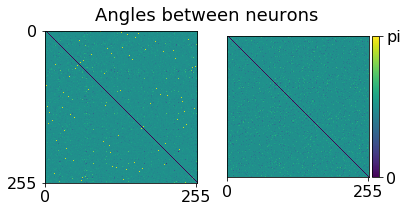

In [8]:
cmap = plt.get_cmap('viridis')
vmin = 0
vmax = np.pi
cNorm = matplotlib.colors.Normalize(vmin=vmin, vmax=vmax)
scalarMap = matplotlib.cm.ScalarMappable(norm=cNorm, cmap=cmap)
scalarMap._A = []
fig, ax = plt.subplots(1, len(neuron_angle_list))
for idx, neuron_angles in enumerate(neuron_angle_list):
  im = ax[idx].imshow(neuron_angles, clim=[vmin,vmax])
  ax[idx].set_xticks([0, analyzers[0].bf_stats["num_outputs"]-1])
  ax[idx].set_yticks([0, analyzers[0].bf_stats["num_outputs"]-1])
  ax[idx].tick_params("both", labelsize=16)
ax[-1].set_yticklabels([])
ax[-1].get_yaxis().set_visible(False)
cbar = pf.add_colorbar_to_im(im, ticks=[vmin, vmax])
cbar.ax.set_yticklabels(["0","pi"])
fig.suptitle("Angles between neurons", y=0.85, fontsize=18)
plt.show()

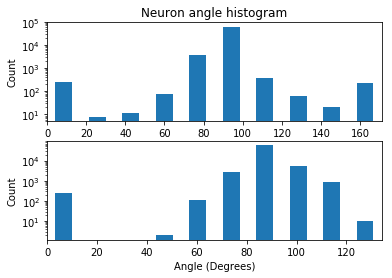

In [9]:
fig, ax = plt.subplots(len(neuron_angle_list))
for idx, neuron_angles in enumerate(neuron_angle_list):
  angles = neuron_angles[np.isfinite(neuron_angles)].flatten()*(180/np.pi)
  xlims = [0, np.max(angles)]
  ax[idx].hist(angles, rwidth=0.5, log=True)
  ax[idx].set_xlim(xlims)
  ax[idx].set_ylabel("Count")
ax[0].set_title("Neuron angle histogram")
ax[1].set_xlabel("Angle (Degrees)")
plt.show()

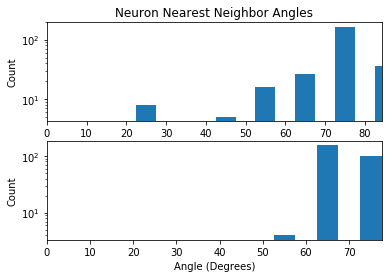

In [10]:
fig, ax = plt.subplots(len(analyzers))
for idx, analyzer in enumerate(analyzers):
  nn_angles = np.zeros(analyzer.bf_stats["num_outputs"])
  for neuron_id in range(analyzer.bf_stats["num_outputs"]): 
    neighbors = neuron_angle_list[idx][neuron_id,:] * (180/np.pi)
    nn_angles[neuron_id] = np.min(np.delete(neighbors, neuron_id))
  ax[idx].hist(nn_angles.flatten(), rwidth=0.5, bins=np.linspace(0,90,10), log=True)
  ax[idx].set_xlim([0, np.max(nn_angles)])
  ax[idx].set_ylabel("Count")
ax[0].set_title("Neuron Nearest Neighbor Angles")
ax[1].set_xlabel("Angle (Degrees)")
plt.show()

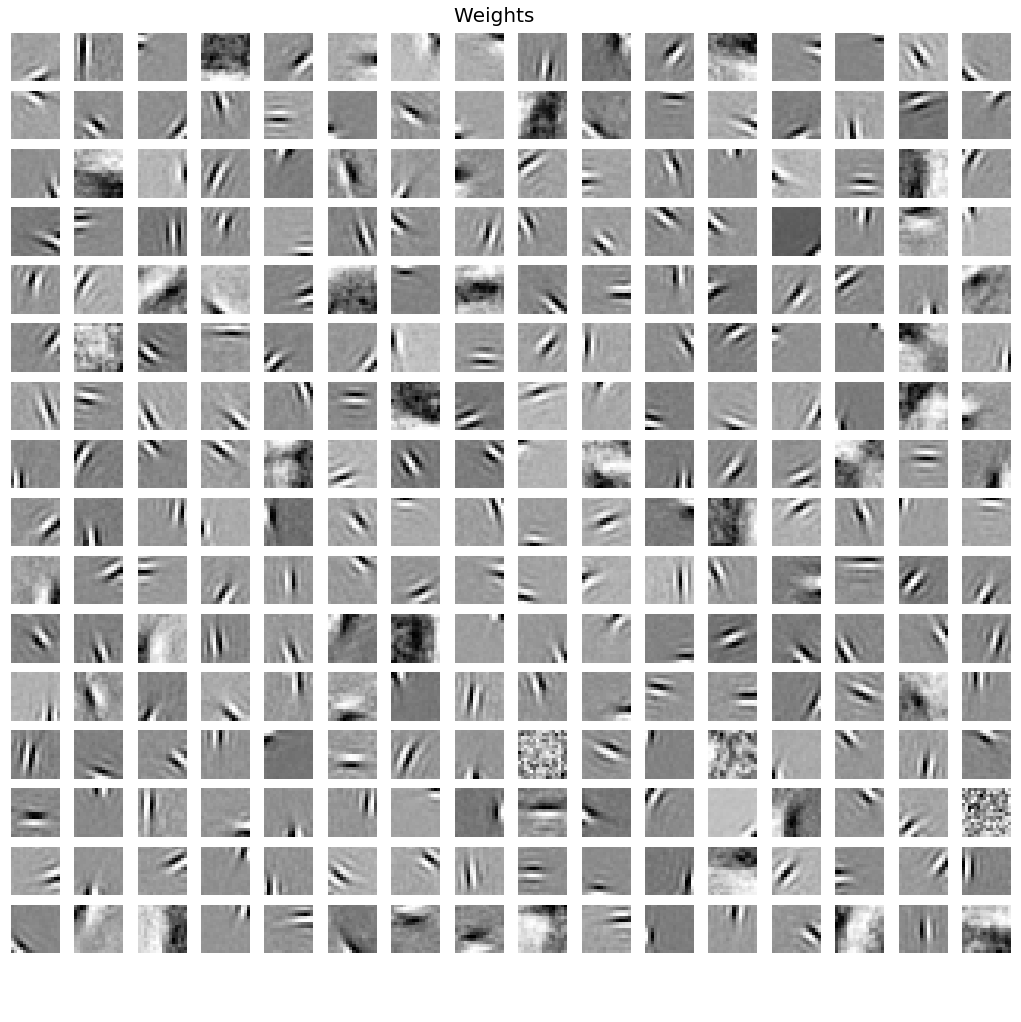

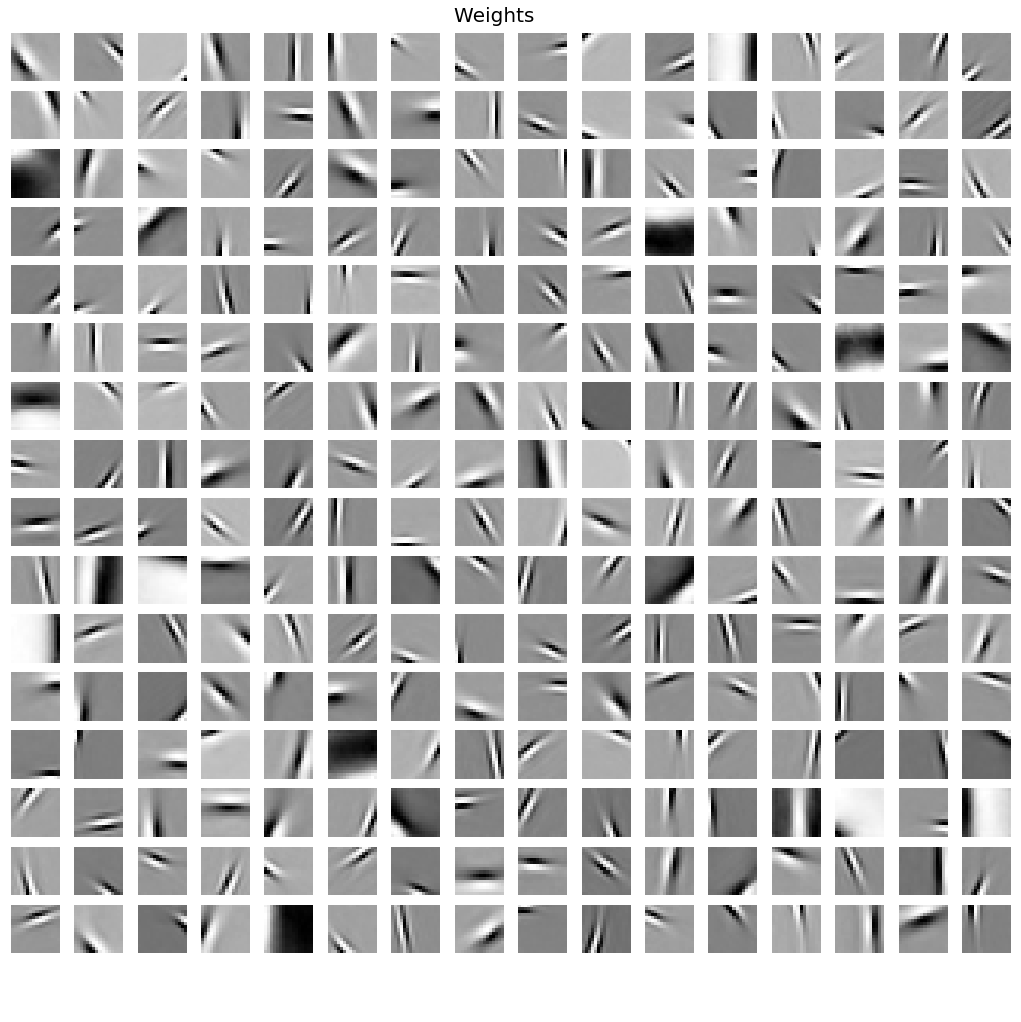

In [11]:
for idx, analyzer in enumerate(analyzers):
  weight_name = analysis_params[idx]["weights"]
  weight_shape = [analyzer.bf_stats["num_outputs"], analyzer.bf_stats["patch_edge_size"], analyzer.bf_stats["patch_edge_size"]]
  dict_fig = pf.plot_weights(analyzer.evals[weight_name].T.reshape(weight_shape), title="Weights")

In [20]:
def plot_loc_freq_summaries(analyzer_list):
  max_sfs = []
  max_envelopes = []
  fig, sub_ax = plt.subplots(1, 3, figsize=(15,5))
  for analyzer in analyzer_list:
    bf_stats = analyzer.bf_stats
    x_pos = [x for (y,x) in bf_stats["gauss_centers"]]
    y_pos = [y for (y,x) in bf_stats["gauss_centers"]]
    sub_ax[0].scatter(x_pos, y_pos, s=13, alpha=0.5, label=analyzer.model_name)
    sub_ax[0].xaxis.set_major_locator(matplotlib.ticker.MaxNLocator(integer=True))
    sub_ax[0].yaxis.set_major_locator(matplotlib.ticker.MaxNLocator(integer=True))
    x_sf = [x for (y,x) in bf_stats["fourier_centers"]]
    y_sf = [y for (y,x) in bf_stats["fourier_centers"]]
    max_sfs.append(np.max(np.abs(x_sf+y_sf)))
    sub_ax[1].scatter(x_sf, y_sf, s=13, alpha=0.5, label=analyzer.model_name)
    sub_ax[1].xaxis.set_major_locator(matplotlib.ticker.MaxNLocator(integer=True))
    sub_ax[1].yaxis.set_major_locator(matplotlib.ticker.MaxNLocator(integer=True))
    widths = [width for ((width, height), _) in bf_stats["gauss_orientations"]]
    heights = [height for ((width, height), _) in bf_stats["gauss_orientations"]]
    max_envelopes.append(np.max([widths, heights]))
    sub_ax[2].scatter(widths, heights, s=13, alpha=0.5, label=analyzer.model_name)
  patch_edge_size = analyzers[0].bf_stats["patch_edge_size"]
  sub_ax[0].set_xlim([0, patch_edge_size-1])
  sub_ax[0].set_ylim([patch_edge_size-1, 0])
  sub_ax[0].set_aspect("equal")
  sub_ax[0].set_ylabel("Pixels")
  sub_ax[0].set_xlabel("Pixels")
  sub_ax[0].set_title("Basis Function Centers", fontsize=12)
  sub_ax[1].set_aspect("equal")
  sub_ax[1].set_ylabel("Cycles / Patch")
  sub_ax[1].set_xlabel("Cycles / Patch")
  sub_ax[1].set_title("Basis Function Spatial Frequencies", fontsize=12)
  sub_ax[1].set_xlim([-np.max(max_sfs), np.max(max_sfs)])
  sub_ax[1].set_ylim([-np.max(max_sfs), np.max(max_sfs)])
  sub_ax[2].set_aspect("equal")
  sub_ax[2].set_ylabel("Envelope Length")
  sub_ax[2].set_xlabel("Envelope Width")
  sub_ax[2].set_title("Basis Function Spatial Receptive Field", fontsize=12)
  sub_ax[2].set_xlim([0, patch_edge_size])
  sub_ax[2].set_ylim([0, patch_edge_size])
  sub_ax[2].legend()
  plt.show()
  return fig

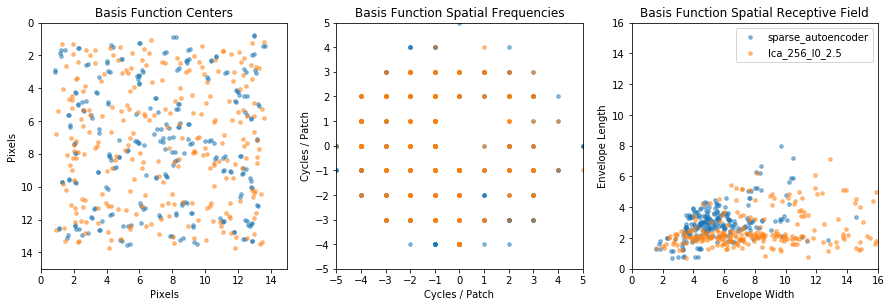

In [21]:
fig = plot_loc_freq_summaries(analyzers)
fig.savefig("/home/dpaiton/fig_location_frequency_centers.png")

In [ ]:
data_batch = data["train"].next_batch(1000)

noise_mean=0.0, noise_std=data_batch.std()
noisy_data_batch = data_batch + analyzers[0].model_params["rand_state"].random.normal(noise_mean,
  noise_std, data_batch.shape)

var_names = ["output/image_estimate/reconstruction:0"]
mse = []
for analyzer in analyzers:
  recons = analyzer.evaluate_model(noisy_data_batch, var_names)[var_names[0]]
  mse.append(dp.compute_mse(data_batch, recons))